<a id="top"></a>
# MIRI MRS Spectroscopy of a Late M Star 2 - Data Anlysis and Visualization

**Use case:** Extract spatial-spectral features from IFU cube and measure their attributes.<br>
**Data:** Simulated [MIRI MRS](https://jwst-docs.stsci.edu/mid-infrared-instrument/miri-observing-modes/miri-medium-resolution-spectroscopy) spectrum of AGB star.<br>
**Source of Simulations:** [MIRISim](https://www.stsci.edu/jwst/science-planning/proposal-planning-toolbox/mirisim)<br>
**Pipeline Version:** [JWST Pipeline](https://jwst-docs.stsci.edu/jwst-data-reduction-pipeline)<br>
**Tools:** specutils, jwst, photutils, astropy, aplpy, scipy.<br>
**Cross-intrument:** NIRSpec, MIRI.<br>
**Documentation:** This notebook is part of a STScI's larger [post-pipeline Data Analysis Tools Ecosystem](https://jwst-docs.stsci.edu/jwst-post-pipeline-data-analysis) and can be [downloaded](https://github.com/spacetelescope/dat_pyinthesky/tree/main/jdat_notebooks/MRS_Mstar_analysis) directly from the [JDAT Notebook Github directory](https://github.com/spacetelescope/jdat_notebooks).<br>

**Note**: This notebook includes MIRI simulated data cubes obtained using MIRISim (https://wiki.miricle.org//bin/view/Public/MIRISim_Public)
and run through the JWST pipeline (https://jwst-pipeline.readthedocs.io/en/latest/) of
point sources with spectra representative of late M type stars.

## Introduction

This notebook analyzes one star represented by a dusty SED corresponding to the ISO SWS spectrum of
W Per from Kraemer et al. (2002) and Sloan et al. (2003) to cover the MRS spectral range 5-28 microns.  Analysis of JWST spectral cubes requires extracting spatial-spectral features of interest and measuring their attributes. 

This is the second notebook, which will perform data analysis using `specutils`.  Specifically, it will fit a model photosphere/blackbody to the spectra.  Then it will calculate the centroids, line integrated flux and equivalent width for each dust and molecular feature. 

**This notebook utilizes reduced data created in the first notebook (JWST_Mstar_dataAnalysis_runpipeline.ipynb), although you don't have to run that notebook to use this notebook. All data created in notebook number 1 are available for download within this noteobok.**

## To Do:
- Make function to extract spectra from datacube using a different means of extraction.
- Replace blackbody fit to the photosphere part of the spectra with a stellar photosphere model.
- Make sure errors have been propagated correctly in the caculation of centroids, line integrated flux and equivalent widths. (Science Author)
- Make simple function within the `specutils` framework to fit a continium and measure centroids, line integrated flux and equivalent widths of broad solid state and molecular features. 

## Import Packages

In [1]:
# Import useful python packages
import numpy as np

# Import packages to display images inline in the notebook
import matplotlib.pyplot as plt    
%matplotlib inline   

# Set general plotting options
params = {'legend.fontsize': '18', 'axes.labelsize': '18',
         'axes.titlesize': '18', 'xtick.labelsize': '18',
         'ytick.labelsize': '18', 'lines.linewidth': 2, 'axes.linewidth': 2, 'animation.html': 'html5'}
plt.rcParams.update(params)
plt.rcParams.update({'figure.max_open_warning': 0})

In [2]:
# Import astropy packages 
from astropy import units as u
from astropy.io import ascii
from astropy.wcs import WCS
from astropy.table import Table, vstack
from astropy.stats import sigma_clipped_stats
from astropy.nddata import StdDevUncertainty
from astropy.io import fits # added by BAS on 8 April 2021
from astropy.utils.data import get_pkg_data_filename
from astropy.utils.data import download_file

# To find stars in the MRS spectralcubes and do aperture photometry
from photutils import DAOStarFinder, CircularAperture

# To deal with 1D spectrum
from specutils import Spectrum1D
from specutils.fitting import fit_generic_continuum
from specutils.manipulation import box_smooth, extract_region, SplineInterpolatedResampler
from specutils.analysis import line_flux, centroid, equivalent_width
from specutils.spectra import SpectralRegion
from specutils import SpectrumList

# To make nice plots with WCS axis
import aplpy

# To fit a curve to the data
from scipy.optimize import curve_fit

In [3]:
# Save and Load Objects Using Pickle
import pickle

def save_obj(obj, name):
    with open(name, 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)


def load_obj(name):
    with open(name, 'rb') as f:
        return pickle.load(f)

In [4]:
def checkKey(dict, key):
      
    if key in dict.keys():
        print("Present, ", end =" ")
        print("value =", dict[key])
        return(True)
    else:
        print("Not present")
        return(False)

In [5]:
import warnings
warnings.simplefilter('ignore')

In [6]:
# Check if Pipeline 3 Reduced data exists and, if not, download it
import os
import urllib.request

if os.path.exists("combine_dithers_all_exposures_ch1-long_s3d.fits"):
    print("Pipeline 3 Data Exists")
else:
    url = 'https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/MRS_Mstar_analysis/reduced.tar.gz'
    urllib.request.urlretrieve(url, './reduced.tar.gz')
    # Unzip Tar Files

    import tarfile

    # Unzip files if they haven't already been unzipped
    if os.path.exists("reduced/"):
        print("Pipeline 3 Data Exists")
    else:
        tar = tarfile.open('./reduced.tar.gz', "r:gz")
        tar.extractall()
        tar.close()
        
    # Move Files 
    os.system('mv reduced/*fits .')

Pipeline 3 Data Exists


Read in 12 spectra from Notebook 1 using [SpectrumList](https://specutils.readthedocs.io/en/stable/api/specutils.SpectrumList.html) and create one master spectrum. 
MIRI MRS data will typically have a separate 1D spectrum and 3D cube associated with each Channel and Sub-Band.

In [7]:
# Read in all X1D spectra to a single spectrum list and combine into a single spectrum1d object

ddd = '.'
splist = SpectrumList.read(ddd)

wlallorig = []
fnuallorig = []
dfnuallorig = []
for bndind in range(len(splist)):
    for wlind in range(len(splist[bndind].spectral_axis)):
        wlallorig.append(splist[bndind].spectral_axis[wlind].value)
        fnuallorig.append(splist[bndind].flux[wlind].value)
        dfnuallorig.append(splist[bndind].uncertainty[wlind].array)

wlallarr = np.array(wlallorig)
fnuallarr = np.array(fnuallorig)
dfnuallarr = np.array(dfnuallorig)
srtind = np.argsort(wlallarr)
wlall = wlallarr[srtind]
fnuall = fnuallarr[srtind]

# Developer Note: We put in errors of 0.0001, but uncertainties need to be fixed
dfnuall = (0.0001)*np.ones(len(fnuall))


#### Developer Note: At this point, the 12 extracted 1D spectra need to get spliced together with a specialty function written for MRS.  

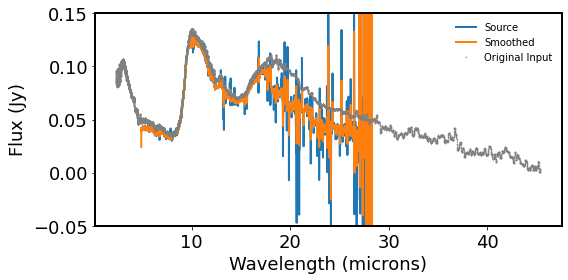

In [8]:
wav = wlall*u.micron # Wavelength: microns
fl = fnuall*u.Jy # Fnu:  Jy
efl = dfnuall*u.Jy # Error flux: Jy

# Make a 1D spectrum object
spec = Spectrum1D(spectral_axis=wav, flux=fl, uncertainty=StdDevUncertainty(efl))

# Apply a 5 pixel boxcar smoothing to the spectrum
spec_bsmooth = box_smooth(spec, width=5)   

# Plot the spectrum & smoothed spectrum to inspect features 
plt.figure(figsize = (8,4))
plt.plot(spec.spectral_axis, spec.flux, label='Source')
plt.plot(spec.spectral_axis, spec_bsmooth.flux, label='Smoothed')
plt.xlabel('Wavelength (microns)')
plt.ylabel("Flux ({:latex})".format(spec.flux.unit))
plt.ylim(-0.05,0.15)

# Overplot the original input spectrum for comparison
origspecfile = fn = download_file('https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/MRS_Mstar_analysis/63702662.txt', cache=False)
origdata = ascii.read(origspecfile)
wlorig = origdata['col1']
fnujyorig = origdata['col2']*0.001 # comes in as mJy, change to Jy to compare with pipeline output
plt.plot(wlorig,fnujyorig, '.', color='grey', markersize=1, label='Original Input')

plt.legend(frameon=False, fontsize='medium')
plt.tight_layout()
plt.show()
plt.close()

## Specviz Visualization

You can also visualize the spectrum list inside a Jupyter notebook using Specviz

## Video1:
    
This Specviz Instructional Demo is from STScI's official YouTube channel and provides an introduction to Cubeviz.

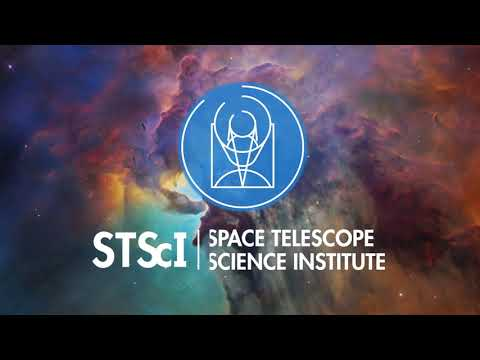

In [9]:
from IPython.display import HTML, YouTubeVideo

vid = YouTubeVideo("zLyRnfG32Bo")
display(vid)

In [10]:
# Open these spectra up in Specviz
from jdaviz import Specviz

specviz = Specviz()
specviz.app

Application(config='specviz', events=['call_viewer_method', 'close_snackbar_message', 'data_item_selected', 'd…

#### Load in the spectrum list from above. Note, only the first spectrum in your list is displayed automatically. You will need to turn on the remaining spectra in the "DATA" drop-down, then hit the "Home" button in the toolbar, and scale our plot accordingly to see the other spectra.

In [11]:
# Load in the spectrum list from above. 
specviz.load_spectrum(splist)

## Cubeviz Visualization

You can also visualize images inside a Jupyter notebook using Cubeviz


## Video2:
    
This Cubeviz Instructional Demo is from STScI's official YouTube channel and provides an introduction to Cubeviz.

In [ ]:
from IPython.display import HTML, YouTubeVideo

vid = YouTubeVideo("HMSYwiH3Gl4")
display(vid)

In [ ]:
from jdaviz import Cubeviz

cubeviz = Cubeviz()
cubeviz.app

#### Developer Note. Need to pick a different unit than meters. https://jira.stsci.edu/browse/JDAT-1792

In [ ]:
# Here, we load the data into the Cubeviz app for visual inspection.  
# In this case, we're just looking at a single channel because, unlike Specviz, Cubeviz can only load a single cube at a time.

ch1short_cubefile = 'combine_dithers_all_exposures_ch1-long_s3d.fits'
cubeviz.load_data(ch1short_cubefile)

Next, you want to define a pixel region subset that is specific to the AGB star.  You can do this with the regions utility button shown in the video below and drawing a circular region around the AGB star at approximate pixels x=20, y=30.

## Video3:
    
Here is a video that quickly shows how to select a spatial region in Cubeviz.

In [ ]:
# Video showing the selection of the star with a circular region of interest
from IPython.display import HTML
HTML('<iframe width="700" height="500" src="https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/MRS_Mstar_analysis/region_select.mov" frameborder="0" allowfullscreen></iframe>')

In [ ]:
# Now extract spectrum from your spectral viewer
spec_agb = cubeviz.app.get_data_from_viewer('spectrum-viewer', 'Subset 1') # AGB star only

#### Developer Note: Since Cubeviz only displays a single cube at a time, you can't extract a full spectrum at the current time. So, you should use the spectrum defined above ('spec')


In [ ]:
spec_agb = spec

## Specviz Visualization

You can visualize the extracted spectrum inside Specviz

In [ ]:
# Open these spectra up in Specviz
specviz = Specviz()
specviz.app

#### Developer Note: Cannot currently open a spectrum1d output from cubeviz in specviz.  https://jira.stsci.edu/browse/JDAT-1791

#specviz.load_spectrum(spec_agb)

In [ ]:
# For now, you must create your own spectrum1d object from your extracted cubeviz spectrum.  
flux = spec_agb.flux
wavelength = spec_agb.spectral_axis
spec1d = Spectrum1D(spectral_axis=wavelength, flux=flux)
specviz.load_spectrum(spec1d)

## Video4:
    
Here is a video that quickly shows how to smooth your spectrum in Specviz.

In [ ]:
# Video showing how to smooth a spectrum in Specviz
HTML('<iframe width="700" height="500" src="https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/MRS_Mstar_analysis/smooth.mov" frameborder="0" allowfullscreen></iframe>')

##  Data analysis 

Analyze the spectrum1d object (spec) created from the spectrumlist list above.

#### Fit a continuum - find the best-fitting template (stellar photosphere model or blackbody)

For AGB stars with a photosphere component fit a stellar photosphere model or a blackbody to short wavelength end of the spectra.

#### Developer Note: Would idealy like to fit the photosphere with a set of Phoenix Models.
I think `template_comparison` may be a good function here to work with the Phoenix Models which have been setup to
interface with `pysynphot`.<br>
For now switching to a blackbody.

## Video5:
    
Here is a video that shows how to fit a blackbody model to the spectrum

In [ ]:
# Video showing how to fit a blackbody 
HTML('<iframe width="700" height="500" src="https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/MRS_Mstar_analysis/blackbody_fit.mov" frameborder="0" allowfullscreen></iframe>')

In [ ]:
spectra = specviz.get_spectra()
   
a = checkKey(spectra, "BB1")
if a is True:
    # Extract Blackbody fit from Specviz
    blackbody = spectra["BB1"]
if a is False:
    print("No Blackbody")
    fn = download_file('https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/MRS_Mstar_analysis/blackbody.fits', cache=False)
    blackbody = Spectrum1D.read(fn)

In [ ]:
# Delete any existing output in current directory
if os.path.exists("blackbody.fits"):
    os.remove("blackbody.fits")
else:
    print("The blackbody.fits file does not exist")

In [ ]:
# Save if you so desire. Keep commented otherwise.
# blackbody.write('blackbody.fits')

In [ ]:
#rename blackbody.flux as ybest
ybest = blackbody.flux

In [ ]:
# Plot the spectrum & the model fit to the short wavelength region of the data.
plt.figure(figsize=(8, 4))
plt.plot(spec.spectral_axis, spec.flux, label='Source')
plt.plot(spec.spectral_axis, ybest, label='BB')
plt.xlabel('Wavelength (microns)')
plt.ylabel("Flux ({:latex})".format(spec.flux.unit))
plt.title("Spectrum with blackbody fit")
plt.legend(frameon=False, fontsize='medium')
plt.tight_layout()
plt.ylim(-0.05, 0.15)
plt.show()
plt.close()

# Now subtract the BB and plot the underlying dust continuum
plt.figure(figsize=(8,4))
plt.plot(spec.spectral_axis, spec.flux.value - ybest.value, color='purple', label='Dust spectra')
plt.axhline(0, color='r', linestyle='dashdot', alpha=0.5)
plt.xlabel('Wavelength (microns)')
plt.ylabel("Flux ({:latex})".format(spec.flux.unit))
plt.title("Continuum-subtracted spectrum")
plt.legend(frameon=False, fontsize='medium')
plt.tight_layout()
plt.ylim(-0.05, 0.15)
plt.show()
plt.close()

### Now have the dust continuum want to look for features and measure their properties.

Want to find:
- Equivalent width
- Equivalent flux
- Optical depth
- Centroids = wavelength with half the flux on either side

#### As an example lets focus on the amorphous silicate 10 micron region.

**Method - used repeatedly**

- Fit a spline to the photosphere continuum subtracted spectra excluding the feature in this fit.
- Trim the spectra to that wavelength region as the spline is now a different size to the full wavelength range of the
spectra.
- Make a continuum subtracted and and continuum normalised spectra.
- Convert the units of the flux from Jy to W/m^2/wavelength for nice units post line integration. 
- Determine the feature line flux in units of W/m^2 and the feature centroid. Use continuum subtracted spectra.
- Determine the feature equivalent width. Use continuum normalised spectra.
- Make sure errors have been propagated correctly.
- Store these results in a table 
- Several molecular and dust features are normally present in the spectra. Repeat for each feature.

**Note**
This seems like a long winded way to do this. Is there a simpler approach?

> For instance a tool that takes four wavelengths, fits a line using the data from  lam0 to lam1 and lam2 to lam3, then
>passes the continuum-subtracted  spectrum for line integration from lam1 to lam2 with error propagation is needed
>several times for dust features. But with the current spectra1d framework this takes many steps to write manually and
>is beyond tedious after doing this for 2 features let alone 20+.  Similar framework is also needed for the integrated
>line centroid with uncertainty, and the extracted equivalent width.

In [ ]:
# Subtract the continuum and plot in a new instance of specviz
bbsub_spectra = spec - ybest.value     # continuum subtracted spectra - Dust only

In [ ]:
specviz = Specviz()
specviz.app

In [ ]:
specviz.load_spectrum(bbsub_spectra)

## Video6:
    
Here is a video that shows how to fit a polynomial to two separate spectral regions within a single subset to remove more underlying continuum

In [ ]:
# Video showing how to fit a polynomial to two separate spectral regions within a single subset
HTML('<iframe width="700" height="500" src="https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/MRS_Mstar_analysis/poly_fit.mov" frameborder="0" allowfullscreen></iframe>')

In [ ]:
spectra = specviz.get_spectra()
   
a = checkKey(spectra, "PolyFit")
if a is True:
    # Extract Blackbody fit from Specviz
    blackbody = spectra["PolyFit"]
if a is False:
    print("No Polyfit")
    fn = download_file('https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/MRS_Mstar_analysis/poly.fits', cache=False)
    poly = Spectrum1D.read(fn)

In [ ]:
# Delete any existing output in current directory
if os.path.exists("poly.fits"):
    os.remove("poly.fits")
else:
    print("The poly.fits file does not exist")

In [ ]:
# Save if you so desire. Keep commented otherwise.
#poly.write('poly.fits')

In [ ]:
# Fit a local continuum between the flux densities at: 8.0 - 8.1 & 14.9 - 15.0 microns
# (i.e. excluding the line itself)

sw_region = 8.0   #lam0
sw_line = 8.1     #lam1
lw_line = 14.9    #lam2
lw_region = 15.0  #lam3

# Zoom in on the line complex & extract
line_reg_10 = SpectralRegion([(sw_region*u.um, lw_region*u.um)])
line_spec = extract_region(bbsub_spectra, line_reg_10)
polysub = extract_region(poly, line_reg_10)
line_y_continuum = polysub.flux

#-----------------------------------------------------------------
# Generate a continuum subtracted and continuum normalised spectra

line_spec_norm   = Spectrum1D(spectral_axis = line_spec.spectral_axis, flux = line_spec.flux/line_y_continuum, uncertainty = StdDevUncertainty(np.zeros(len(line_spec.spectral_axis))))
line_spec_consub = Spectrum1D(spectral_axis = line_spec.spectral_axis, flux = line_spec.flux - line_y_continuum, uncertainty = StdDevUncertainty(np.zeros(len(line_spec.spectral_axis))))

#-----------------------------------------------------------------
# Plot the dust feature & continuum fit to the region

plt.figure(figsize = (8, 4))

plt.plot(line_spec.spectral_axis, line_spec.flux.value,
         label = 'Dust spectra 10 micron region')

plt.plot(line_spec.spectral_axis, line_y_continuum, label = 'Local continuum')

plt.xlabel('Wavelength (microns)')
plt.ylabel("Flux ({:latex})".format(spec.flux.unit))
plt.title("10$\mu$m feature plus local continuum")
plt.legend(frameon = False, fontsize = 'medium')
plt.tight_layout()
plt.show()
plt.close()

#-----------------------------------------------------------------
# Plot the continuum subtracted 10 micron feature

plt.figure(figsize = (8,4))

plt.plot(line_spec.spectral_axis, line_spec_consub.flux, color='green',
         label = 'continuum subtracted')

plt.xlabel('Wavelength (microns)')
plt.ylabel("Flux ({:latex})".format(spec.flux.unit))
plt.title("Continuum subtracted 10$\mu$m feature")
plt.tight_layout()
plt.show()
plt.close()

In [ ]:
#Load 10 um feature back into specviz and calculate the Line flux; Line Centroid; Equivalent width
specviz = Specviz()
specviz.app

In [ ]:
specviz.load_spectrum(line_spec_consub,data_label='Continuum Subtraction')
specviz.load_spectrum(line_spec_norm,data_label='Normalized')

## Video7:
    
Here is a video that shows how to make line analysis measurements within specviz (i.e., line flux, line centroid, equivalent width)<br>
Note: You want to calculate your equivalent width on the normalized spectrum<br>
Note: You can also hack to convert the line flux value into more conventional units<br>

In [ ]:
# Video showing how to measure lines within specviz
HTML('<iframe width="700" height="500" src="https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/MRS_Mstar_analysis/line_analysis_plugin.mov" frameborder="0" allowfullscreen></iframe>')

In [ ]:
# Alternative method to analyze the 10um line within the notebook.
# Calculate the Line flux; Line Centroid; Equivalent width

line_centroid = centroid(line_spec_consub, SpectralRegion(sw_line*u.um, lw_line*u.um))
line_flux_val = line_flux(line_spec_consub, SpectralRegion(sw_line*u.um, lw_line*u.um))

equivalent_width_val = equivalent_width(line_spec_norm)

# Hack to convert the line flux value into more conventional units
# Necessary as spectra has mixed units: f_nu+lambda
line_flux_val = (line_flux_val * u.micron).to(u.W * u.m**-2 * u.micron,
                                              u.spectral_density(line_centroid)) / u.micron

print("Line_centroid: {:.6} ".format(line_centroid))
print("Integrated line_flux: {:.6} ".format(line_flux_val))
print("Equivalent width: {:.6} ".format(equivalent_width_val))

In [ ]:
# Compute the optical depth of the 10 micron feature

tau = -(np.log(line_spec.flux.value / line_y_continuum.value))
optdepth_spec = Spectrum1D(spectral_axis=line_spec.spectral_axis,
                           flux=tau*(u.Jy/u.Jy))
        

In [ ]:
# Plot the optical depth of the 10 micron region vs wavelength
plt.figure(figsize=(10,6))
plt.plot(optdepth_spec.spectral_axis, optdepth_spec.flux)
plt.xlabel("Wavelength ({:latex})".format(spec.spectral_axis.unit))
plt.ylabel('Tau') 
plt.tight_layout()
plt.show()
plt.close()

**Note** At this point repeat *all* the steps above to isolate solid-state features e.g. for the forsterite feature at
at approx 13.3 microns.

This is the end of the notebook that shows some basic analysis of a MIRI MRS spectrum using Cubeviz and Specviz.  Much more analysis is possible.

## Additional Resources

- [PampelMuse](https://gitlab.gwdg.de/skamann/pampelmuse)
- [CASA](https://casa.nrao.edu/Release3.4.0/docs/UserMan/UserManse41.html)

## About this notebook
**Author:** Olivia Jones, Project Scientist, UK ATC.<br>
**Updated On:** 2020-08-11<br>
**Updated On:** 2021-09-06 by B. Sargent, STScI Scientist, Space Telescope Science Institute (added MRS Simulated Data)<br>
**Updated On:** 2021-12-12 by O. Fox, STScI Scientist (added blackbody and polynomial fitting within the notebook)<br>

***

[Top of Page](#top)